# Автокодировщик

In [1]:
import time

import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.nonlinearities import softmax

import matplotlib.pylab as plt
from utils import load_dataset, iterate_minibatches
%matplotlib inline

BATCH_SIZE = 20
HIDDEN_DIM = 2

num_epochs = 40

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

## Обучение модели

tl;dr: Автокодировщик может быть использован для построения маломерных признаков данных без разметки.

В процессе обучения строится пара отображений $E: \mathbb R^D \rightarrow R^d$ (кодировщик) и $D: \mathbb R^d \rightarrow R^D$ (декодировщик), чья композиция приближает тождественное отображение:

$$ D(E(x)) \approx x $$

In [18]:
# Определим кодировщик и декодировщик с помощью пары полносвязных нейронных сетей

def ae_encoder(input_var):
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 28, 28), input_var=input_var)
    ######################################################################################
    # Реализуйте некоторую несложную архитектуру кодировщика, возвращающую HIDDEN_DIM-мерный код #
    # Какие функции активации можно поставить на выход сети?                                  #
    ######################################################################################
    l_in = lasagne.layers.DenseLayer(l_in, num_units=128)
    l_in = lasagne.layers.DenseLayer(l_in, num_units=64)
    l_out = lasagne.layers.DenseLayer(l_in, num_units=HIDDEN_DIM)
    
    return l_out


def ae_decoder(input_var):
    l_in = lasagne.layers.InputLayer(shape=(None, HIDDEN_DIM), input_var=input_var)
    ##################################################################################################
    # Реализуйте некоторую несложную архитектуру декодировщика, возвращающую батч объектов размера (1, 28, 28) #
    ##################################################################################################
    l_in = lasagne.layers.DenseLayer(l_in, num_units=64)
    l_in = lasagne.layers.DenseLayer(l_in, num_units=28*28)
    l_out = lasagne.layers.reshape(l_in, shape=(-1, 1, 28, 28))
    
    return l_out

In [19]:
# Инициализируем сеть
input_x = T.tensor4('input_x')
    
encoder = ae_encoder(input_x)
decoder = ae_decoder(
    lasagne.layers.get_output(encoder)
)

Для обучения автокодировщика будем использовать среднеквадратичную ошибку

$$ L(X) = \frac{1}{N}\sum_{i=1}^{N} \sum_{j=1}^{28^2} \left( D(E(x_i))_j - x_{i,j} \right)^2 = \frac{1}{N}\sum_{i=1}^{N} (D(E(x_i)) - x_i)^T (D(E(x_i)) - x_i) $$

In [20]:
#####################################################################################
# Определите операцию для вычисления функции потерь, а также создайте список параметров модели #
# для передачи в оптимизатор                                                           #
loss = lasagne.objectives.squared_error(
    lasagne.layers.get_output(decoder), input_x
).mean()

params = lasagne.layers.get_all_params(decoder) + lasagne.layers.get_all_params(encoder)
#####################################################################################

updates = lasagne.updates.adam(loss, params)
 
train = theano.function(
    [input_x],
    loss,
    updates=updates
)
test_loss = theano.function(
    [input_x],
    loss
)

Обучение, как и во многих других случаях, выполяется с помощью стохастического градиентного спуска

In [21]:
for epoch in range(num_epochs):
    train_err = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, batchsize=BATCH_SIZE):
        train_err += train(batch)
        train_batches += 1
        
    test_err = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, batchsize=BATCH_SIZE):
        test_err += test_loss(batch)
        test_batches += 1
        
    print("Epoch {} of {} took {:.3f}s".format(
          epoch + 1, num_epochs, time.time() - start_time))
    print("Train error {}".format(train_err/train_batches))
    print("Test error {}".format(test_err/test_batches))

Epoch 1 of 40 took 7.355s
Train error 0.07512219708833404
Test error 0.06626232700628798
Epoch 2 of 40 took 7.002s
Train error 0.06357546538996355
Test error 0.06053020625613677
Epoch 3 of 40 took 8.144s
Train error 0.05923031058077207
Test error 0.05842406646600738
Epoch 4 of 40 took 17.687s
Train error 0.057574738103534966
Test error 0.05675041730225553
Epoch 5 of 40 took 19.983s
Train error 0.056645209939915855
Test error 0.0564429783800569
Epoch 6 of 40 took 21.590s
Train error 0.056096104841341025
Test error 0.05584858217082305
Epoch 7 of 40 took 20.329s
Train error 0.05529721130511625
Test error 0.054915831213428995
Epoch 8 of 40 took 20.823s
Train error 0.054783231459427
Test error 0.05460608909607416
Epoch 9 of 40 took 21.020s
Train error 0.054426491578213984
Test error 0.05447563928800087
Epoch 10 of 40 took 21.305s
Train error 0.05416081495693801
Test error 0.05419985979577539
Epoch 11 of 40 took 21.678s
Train error 0.053964298838416844
Test error 0.05414736754239259
Epoch 12

## Визуализация

Модель с двумерными скрытыми переменными легко визуализировать. Определим две функции: одну для построения пропущенных через автокодировщик изображений, вторую для вычисления скрытых представлений по изображению

In [22]:
from utils import plot_reconstructions, plot_hidden_space

reconstruct = theano.function(
        [input_x],
        lasagne.layers.get_output(decoder)
)

encode = theano.function(
        [input_x],
        lasagne.layers.get_output(encoder)
)

Примеры изображений, пропущенных через автокодировщик: 

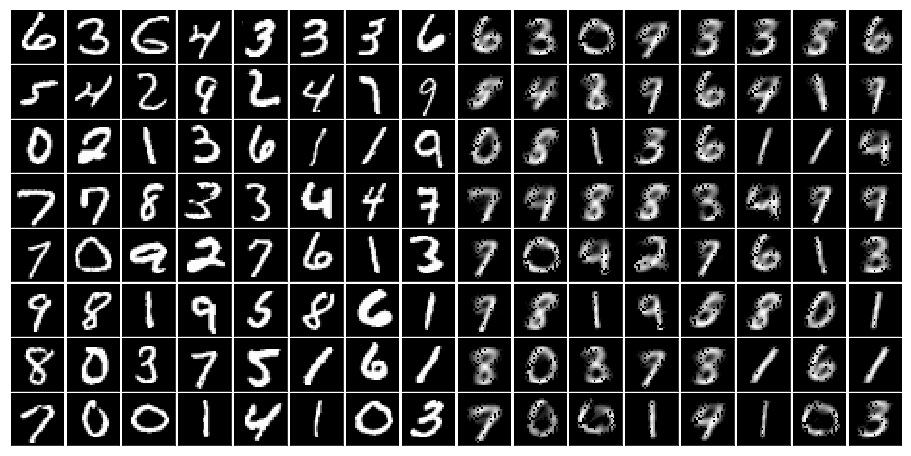

In [23]:
plot_reconstructions(X_test, reconstruct)

Визуализация признакового пространства. Насколько пространство простое? Везде ли оно плотно? Как выбрать точку в этом пространстве, которая будет соответствовать коду какого-то объекта?

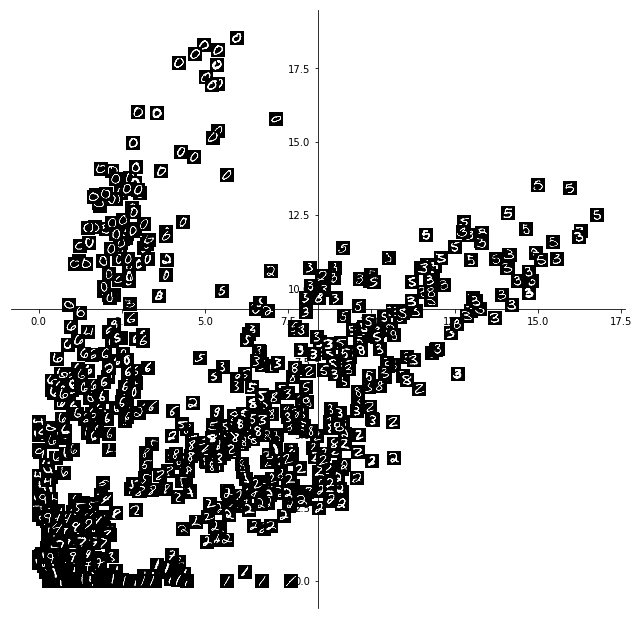

In [24]:
plot_hidden_space(X_test[:1000], encode)

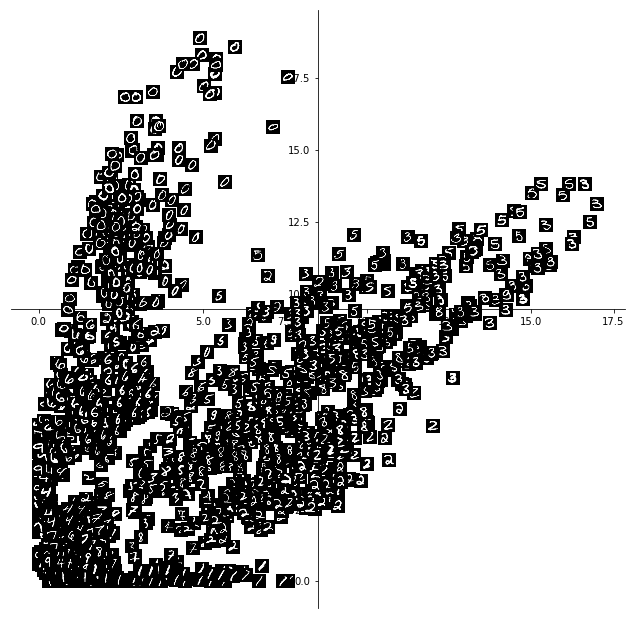

In [33]:
plot_hidden_space(X_test[:2000], encode)

Попробуйте погенерировать изображения по паре координат

In [25]:
input_z = T.matrix('input_z')

decode_a_code = theano.function(
    [input_z],
    lasagne.layers.get_output(decoder, input_z),
)

def generate_from_code(x, y):
    img = decode_a_code([[x, y]]).reshape((28, 28))
    plt.imshow(img, 'gray')

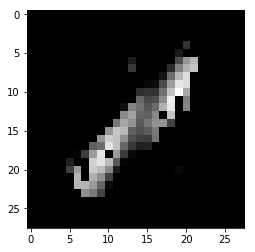

In [30]:
generate_from_code(10., 1.)